# <strong> 1. Prerequisites</strong>

In [ ]:
!pip install numpy
!pip install yfinance
!pip install scipy==1.7
!pip install py_vollib_vectorized 
!pip install nelson-siegel-svensson
!pip install holidays
!pip install seaborn
!pip install torch
!pip install --upgrade pytorch-lightning
!pip install openpyxl
!pip install pandas-market-calendars

ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python <3.12,>=3.8; 1.10.0rc1 Requires-Python <3.12,>=3.8; 1.10.0rc2 Requires-Python <3.12,>=3.8; 1.10.1 Requires-Python <3.12,>=3.8; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11; 1.9.0 Requires-Python >=3.8,<3.12; 1.9.0rc1 Requires-Python >=3.8,<3.12; 1.9.0rc2 Requires-Python >=3.8,<3.12; 1.9.0rc3 Requires-Python >=3.8,<3.12; 1.9.1 Requires-Python >=3.8,<3.12
ERROR: Could not find a version that satisfies the requirement scipy==1.7 (from versions: 0.

In [ ]:
#Common libraries
import os
import time
import datetime
import holidays
import bs4 as bs
import numpy as np
import pandas as pd
import math
import yfinance as yf

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sys
from pandas import DataFrame

# scipy
from scipy.integrate import quad_vec  # quad_vec allows to compute integrals accurately
from scipy.stats import norm
from scipy.optimize import minimize

# from google.colab import files # to save the dataset into CSV files, to save figures
np.random.seed(21) # set a seed for the random generator
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

# scipy
from scipy.integrate import quad_vec  # quad_vec allows to compute integrals accurately
from scipy.optimize import fmin
from scipy.optimize import differential_evolution

#torch
import torch
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl # for reproducible results

# scikit-learn
from sklearn.model_selection import train_test_split

# Nelson-Siegel-Svensson Method for interpolation
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_ns_ols

from deep_neural_network import train, evaluate_model, normalize_dataset, split_dataset, load_data, TwinNetwork, custom_loss, custom_loss_test
import pandas_market_calendars as mcal
from sklearn.metrics import root_mean_squared_error
from Heston import Heston

# <strong> 2. Heston model prices using semi-closed form formulas </strong> 

In [2]:
def beta_function(u, tau, sigma, rho, kappa):
    return kappa - 1j * u * sigma * rho

def alpha_hat_function(u):
    return -0.5 * u * (u + 1j)

def d_function(u, tau, sigma, rho, kappa):
    gamma = 0.5 * sigma**2
    beta = beta_function(u, tau, sigma, rho, kappa)
    alpha_hat = alpha_hat_function(u)
    return np.sqrt(beta**2 - 4 * alpha_hat * gamma)

def g_function(u, tau, sigma, rho, kappa):
    beta = beta_function(u, tau, sigma, rho, kappa)
    d = d_function(u, tau, sigma, rho, kappa)
    return (beta - d) / (beta + d)

def A_function(u, tau, theta, sigma, rho, kappa):
    beta = beta_function(u, tau, sigma, rho, kappa)
    d = d_function(u, tau, sigma, rho, kappa)
    g = g_function(u, tau, sigma, rho, kappa)
    common_term = np.exp(-d*tau)
    A_u = (kappa * theta / (sigma**2)) * ((beta-d)*tau - 2*np.log((g*common_term-1) / (g-1)))    
    return A_u

def B_function(u, tau, sigma, rho, kappa):
    beta = beta_function(u, tau, sigma, rho, kappa)
    d = d_function(u, tau, sigma, rho, kappa)
    g = g_function(u, tau, sigma, rho, kappa)
    common_term = np.exp(-d*tau)
    B_u = ((beta-d) / (sigma**2)) * ((1 - common_term) / (1 - g*common_term))
    return B_u


In [3]:
def heston_charact_funct(u, tau, theta, sigma, rho, kappa, v0):

    beta = beta_function(u, tau, sigma, rho, kappa)    
    #alpha_hat = alpha_hat_function(u)    
    d = d_function(u, tau, sigma, rho, kappa)
    g = g_function(u, tau, sigma, rho, kappa)
    common_term = np.exp(-d*tau)
    A = A_function(u, tau, theta, sigma, rho, kappa)
    B = B_function(u, tau, sigma, rho, kappa)

    return np.exp(A + B * v0)

In [4]:
def integral_price(m, tau, theta, sigma, rho, kappa, v0):
    integrand = (lambda u: 
        np.real(np.exp((1j*u + 0.5)*m)*heston_charact_funct(u - 0.5j, tau, theta, sigma, rho, kappa, v0))/(u**2 + 0.25))

    integ, err = quad_vec(integrand, 0, np.inf)
    return integ

In [5]:
def norm_forw_put_price(lm, r, tau, theta, sigma, rho, kappa, v0):
    m = lm + r*tau #log-moneyness forward
    integ = integral_price(m, tau, theta, sigma, rho, kappa, v0)
    return 1 - (1/np.pi) * integ

In [6]:
def call_price(k, tau, S0, r, theta, sigma, rho, kappa, v0):
    m = np.log(S0/k) + r*tau #log-moneyness forward
    integ = integral_price(m, tau, theta, sigma, rho, kappa, v0)  
    price = S0 - k * np.exp(-r*tau) * integ  /np.pi
         
    return price

# <strong> 3. Heston prices via Differential Machine Learning </strong> 

In [7]:

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("There are {} GPU(s) available.".format(torch.cuda.device_count()))
    print("We will use the GPU: {}".format(torch.cuda.get_device_name(0)))

else:    
    device = torch.device("cpu")
    print("There is no GPU available, we will use the CPU instead.")

There is no GPU available, we will use the CPU instead.


In [8]:
def read_csv(file_name):
    """ read a csv file.
    Args:
        file_name (str): name of the csv file.        

    Returns:
        df: dataframe
    """
    
    directory_path = "./data/"

    file_path = directory_path + file_name

    df = pd.read_csv(file_path, delimiter=',')     

    return df

In [9]:
x, y, dydx = load_data('./data/dataset_100K_feller.csv')

In [10]:
SEED = 21
pl.seed_everything(seed=SEED)

Seed set to 21


21

In [11]:
x_train, x_test, y_train, y_test, dydx_train, dydx_test = split_dataset(x,y,dydx)
x_train_n, x_train_mean, x_train_std, y_train_n, y_train_mean, y_train_std, dydx_train_n, lamda_train_n = normalize_dataset(x_train, y_train, dydx_train)

In [12]:
x_test_n = (x_test - x_train_mean) / x_train_std
y_test_n = (y_test - y_train_mean) / y_train_std
dydx_test_n =  dydx_test * x_train_std / y_train_std 
lambda_test = 1.0 / np.sqrt(np.mean(dydx_test_n**2,axis=0))
lambda_test_tensor = torch.from_numpy(lambda_test).float()


# Convert NumPy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train_n, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_n, dtype=torch.float32).view(-1, 1)
dydx_train_tensor = torch.tensor(dydx_train_n, dtype=torch.float32)
lamda_train_n_tensor = torch.tensor(lamda_train_n, dtype=torch.float32)


y_train_mean_tensor = torch.tensor(y_train_mean, dtype=torch.float32)
y_train_std_tensor = torch.tensor(y_train_std, dtype=torch.float32)
x_train_mean_tensor = torch.tensor(x_train_mean, dtype=torch.float32)
x_train_std_tensor = torch.tensor(x_train_std, dtype=torch.float32)


# Create TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor, dydx_train_tensor)

In [13]:
# Number of input features
nb_inputs = x_train_n.shape[1]
# nb scenarios in the training dataset
size_train = x_train_n.shape[0]

# BEST PARAMETERS
batchesperepoch=16    
batch_size = max(256, size_train // batchesperepoch)
nb_h_layers=6
nb_neurones=50
lr_rate=0.01
nb_epochs=97
gradient_clipping=4


# Create DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

model = TwinNetwork(input_size=nb_inputs, hidden_layers=nb_h_layers, neurons_per_layer=nb_neurones)

In [14]:
# train(model, train_loader, nb_epochs, lr_rate, gradient_clipping)

In [15]:
# Load the model and optimizer state
model = TwinNetwork(input_size=nb_inputs, hidden_layers=nb_h_layers, neurons_per_layer=nb_neurones)
model.load_state_dict(torch.load("model_best.pth"))

mse, custom_loss_value = evaluate_model(model, x_test_n, y_test, dydx_test_n, lambda_test_tensor, x_train_mean, x_train_std, y_train_mean, y_train_std)
print(f'MSE: {mse:.4f}, Custom Loss: {custom_loss_value:.4f}')

MSE: 0.0003, Custom Loss: 0.0407


Best model

# <strong> 4. Calibration process</strong> 

## <Strong><font>4.1. Get Options quotes </font></Strong>

In [32]:
def get_bus_day(ex_date):
    """
    Preprocess options data for neural network training.

    Args:
        options_data (pd.DataFrame): DataFrame containing options data. 
            - complete_calib_data.csv (with the following columns):
            contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest
            ,impliedVolatility,inTheMoney,contractSize,currency,maturity,flag,Price,maturity_years

        min_maturity (float): Minimum maturity value to consider.

    Returns:
        pd.DataFrame: DataFrame containing preprocessed options data.
    """
    eur_holidays = []
    for year in range(2022, 2035):
        days = holidays.EuropeanCentralBank(years=year)
        days.append(datetime.date(year, 12, 31))
        days[datetime.date(year, 12, 31)] = '31 December'
        eur_holidays.extend(days)

    nb_trading_days = 252
    date_obj = datetime.datetime.strptime('31/07/2024', '%d/%m/%Y')

    date_np = np.datetime64(date_obj, 'D')

    maturity_obj = datetime.datetime.strptime(ex_date, '%m/%d/%y')
    maturity_np = np.datetime64(maturity_obj, 'D')

    bus_Day_count = np.busday_count( np.datetime64(date_obj, 'D'),np.datetime64(maturity_obj, 'D'), holidays=eur_holidays)
    print('bus_day_count', bus_Day_count)
  
    return bus_Day_count

get_bus_day('09/19/25')
get_bus_day('07/18/25')

bus_day_count 290
bus_day_count 245


245

## <Strong><font>4.2. Get interest rates </font></Strong>
We get interest rates from US Daily Treasury Par Yield Curve Rates 
https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics?data=yield%27

Then we apply an interpolation method to find the rate corresponding to each maturity. To this end, we will use the Nelson Siegel Svensson method, one of the most common methods of interpolating a curve.

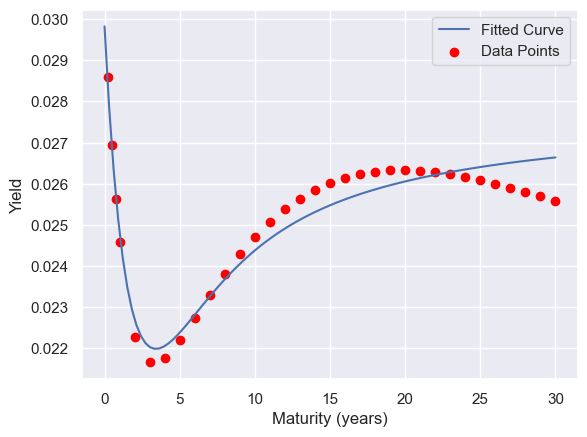

In [17]:
# Nov 5, 2024
yields = np.array([2.860225, 2.693921, 2.561836, 2.457518, 2.227731, 2.165544, 2.176977, 2.219396, 2.272950, 2.328229, 2.380775, 2.428561, 2.470789, 2.507296, 2.538249, 2.563981, 2.584899, 2.601440, 2.614037, 2.623103, 2.629030, 2.632176, 2.632871, 2.631413, 2.628072, 2.623089, 2.616682, 2.609045, 2.600351, 2.590753, 2.580389, 2.569380, 2.557835]).astype(float)/100

yields_maturities= np.array([ 3/12, 6/12, 9/12, 1, 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30 ])

def curve_rates(yields, yields_maturities):    
    curve, status = calibrate_ns_ols(yields_maturities, yields)
    return curve
curve = curve_rates(yields, yields_maturities)

fig, ax = plt.subplots()
x_vals = np.linspace(0, 30, 100)
y_vals = curve(x_vals)
ax.plot(x_vals, y_vals, label='Fitted Curve')
ax.scatter(yields_maturities, yields, color='red', label='Data Points')
ax.set_xlabel('Maturity (years)')
ax.set_ylabel('Yield')
ax.legend()
plt.show()

## <Strong><font>4.3. Calibration data </font></Strong>

In [40]:
# Saving calibration data into CSV files
def read_nd_save(yields, yields_maturities):
    # data = pd.read_excel('./data/grid1_em41bdul.xlsx')
    # near the money is += 10% from S0
    df_puts = pd.read_csv('./data/backtesting_put.csv')
    # print(df_puts.head())

    cleaned_df = pd.DataFrame(columns=['flag', 'maturity', 'strike', 'Price'])
    cleaned_df['strike'] = df_puts['Strike']
    nb_trading_days = 252
    cleaned_df['maturity'] = df_puts['ExDt'].apply(lambda x: get_bus_day(x) / nb_trading_days)
    cleaned_df['Price'] = (df_puts['Bid'] + df_puts['Ask']) / 2
    cleaned_df['flag'] = 'put'

    print(cleaned_df.head())
    cleaned_df.to_csv('./data/put_data_backtest.csv', sep=',', index=False)

    maturities = np.sort(cleaned_df['maturity'].unique())     
    
    # Calculate the risk free rate for each maturity
    curve = curve_rates(yields, yields_maturities)   
    rates = curve(maturities)  

    df_rates = pd.DataFrame(rates, columns = ['rate'])
    
    
    df_rates.to_csv('./data/rate_back.csv', index=False)
    
read_nd_save(yields, yields_maturities)


bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 245
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_count 290
bus_day_co

In [38]:
def read_calib_data(file_puts, file_rates):
    df_puts = pd.read_csv(file_puts)
    df_rates = pd.read_csv(file_rates)
    rates = df_rates[['rate']].to_numpy() 
    rates =  rates.flatten()
    maturities = np.sort(df_puts.maturity.unique()) 
    strikes = np.sort(df_puts.strike.unique()) 
    
    print('nb strikes', strikes.shape)
    print('nb maturities', maturities.shape)
    print('nb rates', rates.shape)
      
    market_prices = np.zeros([len(maturities), len(strikes)])

    for i in range(len(maturities)):
        s = df_puts[df_puts.maturity == maturities[i]]['strike'].to_numpy()
        #print(s)
        for j in range(len(strikes)):       
            if np.isin(strikes[j], s):
                price = df_puts[(df_puts['maturity'] == maturities[i]) & (df_puts['strike'] == strikes[j]) ]['Price']
                price = price.to_numpy()
                market_prices[i,j]= price[0]  
       
    return maturities, strikes, market_prices, rates  

## <Strong><font>4.4. The Objective Function </font></Strong> 

In [41]:
def yhat_nn(model, flag, x, y_t_mean, y_t_std):
    # Pass the input through the model to get the raw prediction
    raw_prediction = model(x)
    
    # Denormalize the prediction
    P_hat = raw_prediction * y_t_std + y_t_mean
    
    return P_hat

def objective_fct_dnn(params, *args):
   
    market_prices = args[0]
    maturities = args[1]
    strikes = args[2]
    rates = args[3]    
    S0 = args[4] 
    model = args[5]    
    x_t_mean = args[6]
    x_t_std = args[7]
    y_t_mean = args[8]
    y_t_std = args[9]
    
    len_maturities = len(maturities)
    len_strikes = len(strikes)

    if len(params)==5:
        theta  = params[0]
        sigma  = params[1]
        rho    = params[2]
        kappa  = params[3]
        v0     = params[4]

    elif len(params)==3:
        theta  = params[0]
        sigma  = params[1]
        rho    = params[2]
        kappa  = args[10]
        v0     = args[11]


    model_prices = np.zeros((len_maturities, len_strikes))
    
    count = 0
    sum = 0
    for i in range(len_maturities):
        for j in range(len_strikes):
            #print(market_prices[i,j])
            if market_prices[i,j]==0.:
                continue

            count  += 1
            T = maturities[i]
            r = rates[i]
            #print('T',T)
            K = strikes[j]
            #print('K',K)

            lm = np.log(S0/K)           
            entries_list = [lm, r, T, theta, sigma, rho, kappa, v0] 
          
            x = np.array(entries_list)
            x = x.reshape(1,-1)
            #transform the numpy arrays to tensors
            x = torch.from_numpy(x).float()
            x = (x-x_t_mean) / x_t_std  

            P_hat = yhat_nn(model, False, x, y_t_mean.to(device), y_t_std.to(device)) 
            model_prices[i,j] = K * P_hat * np.exp(-r*T)

            term = market_prices[i,j] - model_prices[i,j]
            # term = abs(term)
            sum += term**2    
            # sum += term
    
    # mae = sum/count  
    # print(count)  
    rmse = math.sqrt(sum/count)
    # return mae
    return rmse
    

## <Strong><font>4.5. Optimize the objective function using the differential evolution algorithm  </font></Strong> 

In this section, we will calibrate on the last maturity (5.3055 years). 19 strikes and then 19 market prices are quoted for this maturity. 

In [51]:
df_puts = pd.read_csv('./data/put_data_backtest.csv')
maturities, strikes, market_prices, rates = read_calib_data('./data/put_data_backtest.csv', './data/rate_back.csv')
last_maturity = maturities[-1]
print('last maturity is', last_maturity)
df_puts[df_puts['maturity'] == maturities[-1]].info()

nb strikes (54,)
nb maturities (2,)
nb rates (2,)
last maturity is 1.1507936507936507
<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 26 to 70
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   flag      45 non-null     object 
 1   maturity  45 non-null     float64
 2   strike    45 non-null     int64  
 3   Price     45 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.8+ KB


In [46]:
# look at the market data corresponding to the last maturity
df_lastmat = df_puts[df_puts['maturity'] == maturities[-1]]
df_lastmat

,flag,maturity,strike,Price
26,put,1.150794,500,0.450000
27,put,1.150794,800,0.550000
28,put,1.150794,1000,0.700000
29,put,1.150794,2300,8.450000
30,put,1.150794,2400,9.750000
31,put,1.150794,2500,11.250000
32,put,1.150794,2600,12.900000
33,put,1.150794,2700,14.800000
34,put,1.150794,2800,16.900000
35,put,1.150794,2900,19.250000


In [52]:
def optimise_diffevol(objective_fct, bounds, args):

    #params = theta, sigma, rho, kappa, v0
    start_time = time.time()
    opt_params = differential_evolution(objective_fct, bounds=bounds, args=args, strategy='randtobest1bin',
                                        maxiter=120, popsize=50, tol=1e-6, mutation=(0.5, 1),
                                        recombination=0.7, seed=21, callback=None, disp=True, 
                                        polish=True, init='random' 
                                        )
    

    tps = time.gmtime(time.time() - start_time)
    
    return opt_params.x, tps   

In [71]:
def optimal_params(optimise, objec_fct, params, file_puts, file_rates, file_save, S0,
                   model=None, x_t_mean=None, x_t_std=None, y_t_mean=None,
                   y_t_std=None, kappa=None, v0=None):
    
    maturities, strikes, market_prices, rates = read_calib_data(file_puts, file_rates)

    # choose the last maturity 
    # CHECK AGAIN WHETHER RATES AND MARKET PRICES ARE CORRECT by def read_calib_data 

    #nb maturities (32,)
    # maturities    = maturities[31:32]
    # rates         = rates[31:32]
    # market_prices = market_prices[31:32,:]

    #nb maturities (1,)
    # maturities = maturities[0:1]

    # rates         = rates[0:1]
    
    # market_prices = market_prices[0:1,:]

    #nb maturities (2,)
    maturities = maturities[1:2]
    rates         = rates[1:2]
    market_prices = market_prices[1:2,:]


    args = (market_prices, maturities, strikes, rates, S0, model, x_t_mean, x_t_std, y_t_mean, y_t_std)   


    opt_params, tps = optimise(objec_fct, params, args)   

    
    tps = time.strftime('%H:%M:%S', tps)
    
    theta = opt_params[0]
    sigma = opt_params[1]
    rho   = opt_params[2]
    kappa = opt_params[3]
    v0    = opt_params[4]

    # print("theta", theta)
    # print("sigma", sigma)
    # print("rho", rho)
    # print("kappa", kappa)
    # print("v0", v0)

    dict_param = {"theta":theta, 
                  "sigma":sigma, 
                  "rho":rho,
                  "kappa":kappa,
                  "v0":v0,
                  "time":tps}
                         
    df_optparams = pd.DataFrame(dict_param, index=[0]) 

    with open(file_save, 'a') as f:
        df_optparams.to_csv(f, sep=',', index=False, header=f.tell()==0)
       

    return opt_params, tps

### 4.5.2 Optimization when the model prices are calculated via Differential Deep Learning
The following algorithm takes 5 minutes and 28 seconds to run.

In [72]:
bounds = [(0.0,1.), (0.1,2.), (-0.90,0.0), (0.005,3.), (0.,1.)]  

S0 = 4871 # current price of the underlying asset

opt_params_diffevol_dnn, tps_diff_evol_dnn  = optimal_params(optimise= optimise_diffevol, objec_fct=objective_fct_dnn, params=bounds, file_puts='./data/put_data_backtest.csv', 
               file_rates='./data/rate_back.csv', file_save='./data/diffevol_calibdnn_backtest.csv', S0=S0,
               model=model, x_t_mean=x_train_mean_tensor, x_t_std=x_train_std_tensor, y_t_mean=y_train_mean_tensor,
               y_t_std=y_train_std_tensor, kappa=None, v0=None)


print(f'optimal params are: {opt_params_diffevol_dnn}') 
print("The neural network based calibration process takes :", tps_diff_evol_dnn)
# first maturity [ 6.20792492e-05  1.03492111e-01 -7.78000323e-01  5.10080353e-03 6.90092809e-03]

nb strikes (54,)
nb maturities (2,)
nb rates (2,)
differential_evolution step 1: f(x)= 30.210270270216704
differential_evolution step 2: f(x)= 30.210270270216704
differential_evolution step 3: f(x)= 30.210270270216704
differential_evolution step 4: f(x)= 30.210270270216704
differential_evolution step 5: f(x)= 30.210270270216704
differential_evolution step 6: f(x)= 30.210270270216704
differential_evolution step 7: f(x)= 20.570382047050842
differential_evolution step 8: f(x)= 20.570382047050842
differential_evolution step 9: f(x)= 20.37814515107595
differential_evolution step 10: f(x)= 20.37814515107595
differential_evolution step 11: f(x)= 20.37814515107595
differential_evolution step 12: f(x)= 19.110491392859547
differential_evolution step 13: f(x)= 19.110491392859547
differential_evolution step 14: f(x)= 10.912238056571313
differential_evolution step 15: f(x)= 10.912238056571313
differential_evolution step 16: f(x)= 10.271457374270733
differential_evolution step 17: f(x)= 10.271457374

### 4.5.3 Comparing the option prices by computing average absolute error

In [73]:
file_puts='./data/put_data_backtest.csv'
file_rates='./data/rate_back.csv'
df_puts = pd.read_csv('./data/put_data_backtest.csv')
maturities, _, market_prices, rates = read_calib_data(file_puts, file_rates)
# print(maturities)
# print(rates)
# choose the last maturity 
T = maturities[-1]
#print(T)
r = rates[-1]
#print(r)
# strikes that correspond to the last maturity are 
strikes = df_puts[df_puts['maturity'] == T]['strike'].tolist()
#print(strikes)
mrk_prices = df_puts[df_puts['maturity'] == T]['Price'].tolist()


nb strikes (54,)
nb maturities (2,)
nb rates (2,)


In [76]:
def price_clsed_form(theta, sigma, rho, kappa, v0, T, r, strikes, S0):

    len_strikes = len(strikes)
    #print(len(strikes))
    model_prices = []
   
    for i in range(len_strikes):
        K = strikes[i]
        #print('K',K)            
        lm = np.log(S0/K)          
        P_hat = norm_forw_put_price(lm, r, T, theta, sigma, rho, kappa, v0)
            
        model_prices.append(K * np.exp(-r*T) * P_hat)
            
    return model_prices


In [77]:
theta = opt_params_diffevol_dnn[0]
sigma = opt_params_diffevol_dnn[1]
rho = opt_params_diffevol_dnn[2]
kappa = opt_params_diffevol_dnn[3] 
v0 = opt_params_diffevol_dnn[4]

prices_dnn = price_clsed_form(theta, sigma, rho, kappa, v0, T, r, strikes, S0)  
abs_err_tradcal = [] 
for i, j in zip(prices_dnn, mrk_prices): 
    abs_err_tradcal.append(abs(i - j)) 

av_ab_err_tradcal =  sum(abs_err_tradcal, 0) / len(abs_err_tradcal)
print('Absolute error (NN based calibration) is:', abs_err_tradcal)
print('Average absolute error (NN based calibration) is: {}'.format(av_ab_err_tradcal))

Absolute error (NN based calibration) is: [0.4499999824234852, 0.5499998061584412, 0.6999962341764117, 8.43677549256317, 9.729861355815515, 11.219855371387247, 12.85558763868232, 14.735520441555641, 16.807648238780256, 19.11938894935975, 21.767432160117856, 24.747630008551873, 28.10469295355332, 31.882085142568908, 36.27168167409957, 41.31348155828264, 47.04525691056768, 53.752132071331154, 61.41609645863415, 70.31547789191097, 80.47429621114348, 92.26149351719285, 105.59002614978249, 120.96543861655934, 129.54181991510876, 138.68369923266494, 158.7765098016484, 181.80050318800315, 208.15838382458853, 238.2111537863801, 254.17585819509065, 271.63052556898083, 288.9638169244711, 304.9153714905305, 294.7952629986556, 259.09187705423307, 225.75444720783008, 196.95421939002762, 172.64868754128196, 152.71049018123006, 136.5957909020898, 123.76016924260216, 113.58378053369961, 105.68374639169815, 99.36973794133041]
Average absolute error (NN based calibration) is: 110.3626156921632


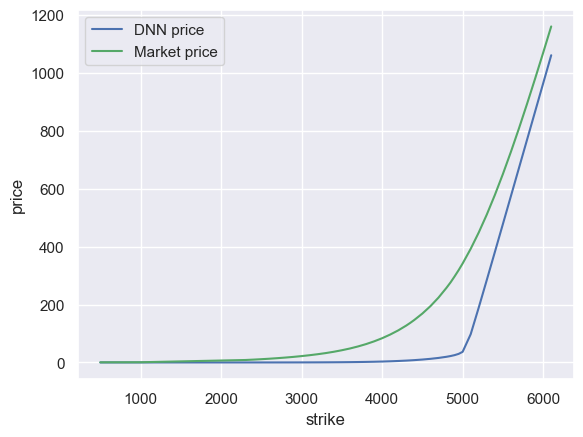

In [78]:
fig = plt.figure()
plt.plot(strikes, prices_dnn, color='b', label='DNN price')
plt.plot(strikes, mrk_prices, color='g', label='Market price')

plt.xlabel('strike')
plt.ylabel('price')
plt.legend()

plt.show()


In [84]:
underlying_ticker = yf.Ticker("^STOXX50E")
start_date = '2024-07-31'

end_date = '2024-11-01'
price_history_matrix = underlying_ticker.history(period="1y", start = '2022-07-12', end = end_date)
price_history = price_history_matrix['Close']

underlying_asset_full_duration = underlying_ticker.history(period="1y", start = start_date, end = end_date)
price_backtest_true = underlying_asset_full_duration['Close']

print(price_backtest_true)
print(len(price_backtest_true))

Date
2024-07-31 00:00:00+02:00    4872.939941
2024-08-02 00:00:00+02:00    4638.700195
2024-08-05 00:00:00+02:00    4571.600098
2024-08-06 00:00:00+02:00    4575.220215
2024-08-07 00:00:00+02:00    4668.060059
                                ...     
2024-10-25 00:00:00+02:00    4943.089844
2024-10-28 00:00:00+01:00    4969.830078
2024-10-29 00:00:00+01:00    4950.020020
2024-10-30 00:00:00+01:00    4885.750000
2024-10-31 00:00:00+01:00    4827.629883
Name: Close, Length: 66, dtype: float64
66


In [85]:


# product lifetime from backtesting date (2024-08-01 is business day)
eurex = mcal.get_calendar('EUREX')
product_lifetime = eurex.schedule(start_date='2024-07-31', end_date='2025-07-21')
print(len(product_lifetime))


248


In [86]:
start_date = '2024-07-31'
end_date = '2024-11-01'
tickers=["^STOXX50E"]

window_size = 252
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

start_date = start_date.tz_localize('Europe/Zurich')
end_date = end_date.tz_localize('Europe/Zurich')

price_history_matrix = underlying_ticker.history(period="1y", start = '2022-07-12', end = end_date)
price_history = price_history_matrix['Close'].values

# product_prices["date"] = pd.to_datetime(product_prices["date"])
# product_prices = product_prices.set_index("date")
simulation_dates = price_history_matrix.index[(price_history_matrix.index >= start_date) & (price_history_matrix.index <= end_date)]

print(f"{len(simulation_dates)} days")
# print(f"Start Date: {simulation_dates[0]}; End date: {simulation_dates[-1]}")
print(simulation_dates)

66 days
DatetimeIndex(['2024-07-31 00:00:00+02:00', '2024-08-02 00:00:00+02:00',
               '2024-08-05 00:00:00+02:00', '2024-08-06 00:00:00+02:00',
               '2024-08-07 00:00:00+02:00', '2024-08-08 00:00:00+02:00',
               '2024-08-09 00:00:00+02:00', '2024-08-12 00:00:00+02:00',
               '2024-08-13 00:00:00+02:00', '2024-08-14 00:00:00+02:00',
               '2024-08-15 00:00:00+02:00', '2024-08-16 00:00:00+02:00',
               '2024-08-19 00:00:00+02:00', '2024-08-20 00:00:00+02:00',
               '2024-08-21 00:00:00+02:00', '2024-08-22 00:00:00+02:00',
               '2024-08-23 00:00:00+02:00', '2024-08-26 00:00:00+02:00',
               '2024-08-27 00:00:00+02:00', '2024-08-28 00:00:00+02:00',
               '2024-08-29 00:00:00+02:00', '2024-08-30 00:00:00+02:00',
               '2024-09-02 00:00:00+02:00', '2024-09-03 00:00:00+02:00',
               '2024-09-04 00:00:00+02:00', '2024-09-05 00:00:00+02:00',
               '2024-09-06 00:00:00+02:00',

In [87]:
# We shall sample a window of size 252 from the historical data (EXCLUDING the current date)
backtest_windows = []   # Prices only
backtest_windows_with_dates = []
previous_window_end_date = None

for window_end_date in simulation_dates:
    # For each date the product was prices, we need 252 points BEFORE this date
    try:
        window_start_index = price_history_matrix.index.get_loc(window_end_date) - window_size
    except:
        window_start_index = price_history_matrix.index.get_loc(previous_window_end_date) - window_size + 1
        print(f"Asset not priced on {window_end_date}. Using data up till the previous date!")

    assert window_start_index >= 0

    # Slice the dataset according to the window
    window_start_date = price_history_matrix.index[window_start_index]
    window_asset_data = price_history_matrix[(price_history_matrix.index >= window_start_date) & (price_history_matrix.index < window_end_date)]

    # Collect all the windows
    assert len(window_asset_data) == window_size
    backtest_windows_with_dates.append(window_asset_data)   # For validatiuon purposes
    backtest_windows.append(np.array(window_asset_data['Close']))
    
    # For handling edge cases in the try-except block
    previous_window_end_date = window_end_date

print(f"Collected data for {len(backtest_windows)} windows of size {window_size} each.")
print(backtest_windows)

Collected data for 66 windows of size 252 each.
[array([4471.31005859, 4336.5       , 4304.62988281, 4332.91015625,
       4337.5       , 4288.85009766, 4317.33007812, 4384.04003906,
       4321.33007812, 4330.22998047, 4288.56982422, 4284.27001953,
       4227.83007812, 4212.95019531, 4224.87011719, 4260.37011719,
       4266.66992188, 4232.22021484, 4236.25      , 4293.68994141,
       4326.47021484, 4315.31005859, 4297.10986328, 4282.64013672,
       4279.87011719, 4269.16015625, 4238.25976562, 4221.02001953,
       4237.18994141, 4254.33007812, 4242.27001953, 4223.47998047,
       4279.75      , 4295.04980469, 4245.87988281, 4242.70019531,
       4275.97998047, 4212.58984375, 4207.16015625, 4167.37011719,
       4129.18017578, 4131.68017578, 4161.56005859, 4174.66015625,
       4137.62988281, 4095.59008789, 4099.85009766, 4099.81005859,
       4144.43017578, 4112.56982422, 4205.22998047, 4200.79980469,
       4198.22998047, 4136.12011719, 4149.85986328, 4152.31982422,
       4105.8

In [88]:
# ECB rates
raw_ecb = pd.read_csv('./data/rate_yield_data.csv')

clean_ecb = raw_ecb[['DATA_TYPE_FM', 'TIME_PERIOD', 'OBS_VALUE']]
clean_ecb['TIME_PERIOD'] = pd.to_datetime(clean_ecb['TIME_PERIOD']).dt.tz_localize('Europe/Zurich')
clean_ecb = clean_ecb[clean_ecb['DATA_TYPE_FM'].str.startswith('BETA') | clean_ecb['DATA_TYPE_FM'].str.startswith('TAU')]
clean_ecb.head()
clean_ecb.to_csv('./data/cleaned_ecb.csv', index=False)

In [89]:
curves = []
for date in simulation_dates:
    print(f"Processing date {date}")

    date_data = clean_ecb[clean_ecb['TIME_PERIOD'] == date]
    
    # Extract parameters, handling potential missing data
    interest_rate_values = []
    parameter_names = ['BETA0', 'BETA1', 'BETA2', 'BETA3', 'TAU1', 'TAU2']
    for param_name in parameter_names:
        value = date_data[date_data['DATA_TYPE_FM'] == param_name]['OBS_VALUE'].iloc[0]
        interest_rate_values.append(value)
        print(f"{param_name}: {value}")
        
    curve = NelsonSiegelSvenssonCurve(beta0=interest_rate_values[0], beta1=interest_rate_values[1], beta2=interest_rate_values[2], beta3=interest_rate_values[3], tau1=interest_rate_values[4], tau2=interest_rate_values[5])
    curves.append(curve)

Processing date 2024-07-31 00:00:00+02:00
BETA0: 0.3915583086
BETA1: 3.0451370045
BETA2: -5.791534985
BETA3: 9.3303548488
TAU1: 4.0766465044
TAU2: 10.0304556532
Processing date 2024-08-02 00:00:00+02:00
BETA0: 0.3390056237
BETA1: 3.0380288269
BETA2: -6.0242226269
BETA3: 9.3026874589
TAU1: 4.045638733
TAU2: 10.0283154317
Processing date 2024-08-05 00:00:00+02:00
BETA0: 0.3761705095
BETA1: 3.0740215299
BETA2: -2.3527498285
BETA3: 6.7563136942
TAU1: 2.176627396
TAU2: 11.5181712562
Processing date 2024-08-06 00:00:00+02:00
BETA0: 0.4420052911
BETA1: 3.1254495985
BETA2: -1.7411394107
BETA3: 6.384403285
TAU1: 1.8124725055
TAU2: 11.936754293
Processing date 2024-08-07 00:00:00+02:00
BETA0: 0.4639879009
BETA1: 3.1012588506
BETA2: -1.7670729142
BETA3: 6.697981264
TAU1: 1.9326318804
TAU2: 11.9802541242
Processing date 2024-08-08 00:00:00+02:00
BETA0: 0.4444903428
BETA1: 3.0970815094
BETA2: -2.3895880634
BETA3: 6.958268737
TAU1: 2.2386263727
TAU2: 11.4570591589
Processing date 2024-08-09 00:00:00

In [93]:
def get_stats(variances):
  mu = np.mean(variances)
  sigma = np.std(variances, ddof=1)
  reversion_rate = 1
  return mu, sigma, reversion_rate, variances[len(variances)-1]

def loss(inp, variances, log_prices):
    r, reversion, mean_var, sigma_var, rho = inp
    sigma_var=sigma_var**(1/2)
    term = 0.0
    for i in range(1,len(variances)):
        var = variances[i-1]
        nextvar = variances[i]
        term += -np.log(2*3.1415) - np.log(sigma_var) -np.log(var) - 1/2*np.log(1-rho**2) - (nextvar-1-r)**2/(2*var*(1-rho**2))+ rho*(nextvar-1-r)*(nextvar-var-reversion*mean_var+reversion*var)/(var*sigma_var*(1-rho**2) - (nextvar-var-reversion*mean_var+reversion*var)**2/(2*(sigma_var**2)*var*(1-rho**2)))
    return term

def get_lognormal_statistics(prices):
  log_data = np.log(prices)
  log_returns = log_data[1:] - log_data[:-1]
  mu = np.mean(log_returns)
  dev_2 = (log_returns-mu)**2
  correlation = pd.Series(log_returns).corr(pd.Series(dev_2))
  mean_sigma, sigma_sigma, reversion, var_inint = get_stats(dev_2)
  # res = minimize(lambda x: loss(x,log_returns, dev_2), (mu,reversion,mean_sigma,sigma_sigma, correlation)).x
  return mu, var_inint


In [94]:
price_history_m = underlying_ticker.history(period="1y", start = '2022-07-12', end = '2024-08-01')
price_history_m = price_history_matrix['Close']
price_history_m.values

array([3487.05004883, 3453.9699707 , 3396.61010742, 3477.19995117,
       3511.86010742, 3587.43994141, 3585.23999023, 3596.51000977,
       3596.48999023, 3604.15991211, 3575.36010742, 3607.7800293 ,
       3652.19995117, 3708.10009766, 3684.62988281, 3732.54003906,
       3754.60009766, 3725.38989258, 3757.2199707 , 3715.37011719,
       3749.35009766, 3757.05004883, 3776.81005859, 3789.62011719,
       3805.2199707 , 3756.06005859, 3777.37988281, 3730.32006836,
       3658.2199707 , 3652.52001953, 3667.45996094, 3674.54003906,
       3603.67993164, 3570.51000977, 3561.91992188, 3517.25      ,
       3456.69995117, 3544.37988281, 3490.01000977, 3500.13989258,
       3502.09008789, 3512.37988281, 3570.04003906, 3646.51000977,
       3586.17993164, 3567.56005859, 3541.79003906, 3500.40991211,
       3499.48999023, 3467.09008789, 3491.87011719, 3427.13989258,
       3348.60009766, 3342.56005859, 3328.64990234, 3335.30004883,
       3279.04003906, 3318.19995117, 3342.16992188, 3484.47998

In [126]:
Nsim = 1000
price_backtest_heston_qe_av_without_martingale = []
price_backtest_heston_qe_without_martingale = []
price_backtest_heston_qe_av_with_martingale = []
price_backtest_heston_qe_with_martingale = []

derivative_backtest_heston_qe_with_martingale = []
derivative_backtest_heston_qe_av_with_martingale = []
derivative_backtest_heston_qe_av_cv_with_martingale = []
derivative_backtest_heston_qe_cv_with_martingale = []  

derivative_backtest_heston_qe_without_martingale = []
derivative_backtest_heston_qe_av_without_martingale = []
derivative_backtest_heston_qe_av_cv_without_martingale = []
derivative_backtest_heston_qe_cv_without_martingale = []

opt_params_diffevol_dnn = [ 6.20792492e-05 , 1.03492111e-01, -7.78000323e-01 , 5.10080353e-03, 6.90092809e-03]
# opt_params_diffevol_dnn = [ 9.71771080e-06,  2.01993211e-01, -7.25982071e-01,  5.00588924e-03, 1.42320536e-03]
for date, prices in zip(simulation_dates, backtest_windows):
    delta_t = 1/252 

    date_index = simulation_dates.get_loc(date)

    curve_fit = curves[date_index]  


    delta = len(product_lifetime[date_index:])
    tau = delta / 252 ### time diff in years

    num_steps =  int(tau/delta_t)

    rate = curve_fit(tau) ### yearly interest

    mu, var_inint= get_lognormal_statistics(prices)  ### all daily indicators

    # opt_params_diffevol_dnn = [ 0.00203402,  0.29570897, -0.49303192,  0.00501894,  0.04218995]
    heston = Heston(S0 = prices[-1], T = tau, r = rate, q = 3/100, mu = mu, theta = opt_params_diffevol_dnn[0], sigma = opt_params_diffevol_dnn[1], rho = opt_params_diffevol_dnn[2], kappa = opt_params_diffevol_dnn[3], V0 =var_inint, barrier = 1743.525, price_history_matrix = price_history_m.values)
    paths_qe_av_with_martingale = heston.QE_simulate_AV(n_trials=Nsim, n_steps=num_steps, martingale_correction=True)
    path_qe_with_martingale = heston.QE_simulate(n_trials=Nsim, n_steps=num_steps, martingale_correction=True)
    paths_qe_av_without_martingale = heston.QE_simulate_AV(n_trials=Nsim, n_steps=num_steps, martingale_correction=False)
    path_qe_without_martingale = heston.QE_simulate(n_trials=Nsim, n_steps=num_steps, martingale_correction=False)

    expected_price_qe_av_with_martingale = np.mean(paths_qe_av_with_martingale[:,-2])
    expected_price_qe_with_martingale = np.mean(path_qe_with_martingale[:,-2])
    expected_price_qe_av_without_martingale = np.mean(paths_qe_av_without_martingale[:,-2])
    expected_price_qe_without_martingale = np.mean(path_qe_without_martingale[:,-2])

    price_backtest_heston_qe_av_with_martingale.append(expected_price_qe_av_with_martingale)
    price_backtest_heston_qe_with_martingale.append(expected_price_qe_with_martingale)
    price_backtest_heston_qe_av_without_martingale.append(expected_price_qe_av_without_martingale)
    price_backtest_heston_qe_without_martingale.append(expected_price_qe_without_martingale)

    # derivative_qe_av_with_martingale, _ = heston.Pricer(paths_qe_av_with_martingale)
    # derivative_qe_with_martingale, _  = heston.Pricer(path_qe_with_martingale)
    # derivative_qe_av_cv_with_martingale, _  = heston.CVPricer(paths_qe_av_with_martingale)
    # derivative_qe_cv_with_martingale, _  = heston.CVPricer(path_qe_with_martingale)

    # derivative_qe_av_without_martingale, _ = heston.Pricer(paths_qe_av_without_martingale)
    # derivative_qe_without_martingale, _  = heston.Pricer(path_qe_without_martingale)
    # derivative_qe_av_cv_without_martingale, _  = heston.CVPricer(paths_qe_av_without_martingale)
    # derivative_qe_cv_without_martingale, _  = heston.CVPricer(path_qe_without_martingale)


    # derivative_backtest_heston_qe_with_martingale.append(derivative_qe_with_martingale)
    # derivative_backtest_heston_qe_av_with_martingale.append(derivative_qe_av_with_martingale)
    # derivative_backtest_heston_qe_av_cv_with_martingale.append(derivative_qe_av_cv_with_martingale)
    # derivative_backtest_heston_qe_cv_with_martingale.append(derivative_qe_cv_with_martingale)

    # derivative_backtest_heston_qe_without_martingale.append(derivative_qe_without_martingale)
    # derivative_backtest_heston_qe_av_without_martingale.append(derivative_qe_av_without_martingale)
    # derivative_backtest_heston_qe_av_cv_without_martingale.append(derivative_qe_av_cv_without_martingale)
    # derivative_backtest_heston_qe_cv_without_martingale.append(derivative_qe_cv_without_martingale)
    



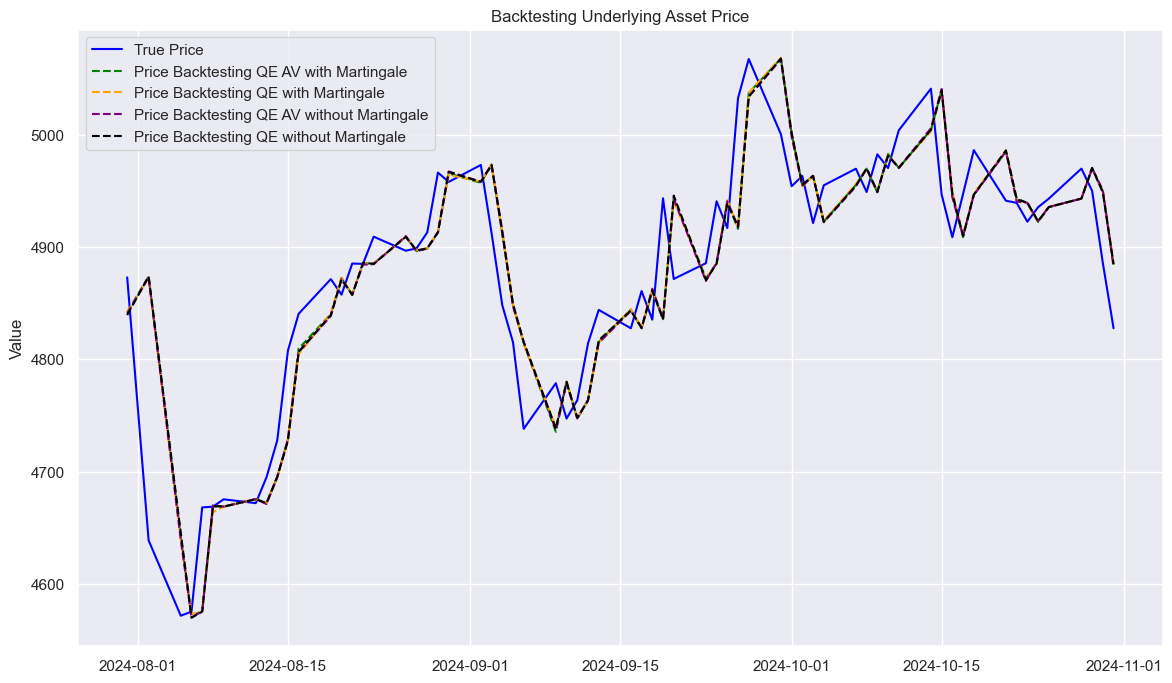

MSE for QE AV with Martingale: 1.204637434273882
MSE for QE with Martingale: 2721.8402102538375
MSE for QE AV without Martingale: 1.157435783643774
MSE for QE without Martingale: 1.4920583584032743


In [128]:
plt.figure(figsize=(14,8))

plt.plot(price_backtest_true.index, price_backtest_true, label="True Price", color="blue", linestyle="-")  
plt.plot(price_backtest_true.index, price_backtest_heston_qe_av_with_martingale, label="Price Backtesting QE AV with Martingale", color="green", linestyle="--")   
plt.plot(price_backtest_true.index, price_backtest_heston_qe_with_martingale, label="Price Backtesting QE with Martingale", color="orange", linestyle="--")  
plt.plot(price_backtest_true.index, price_backtest_heston_qe_av_without_martingale, label="Price Backtesting QE AV without Martingale", color="purple", linestyle="--")
plt.plot(price_backtest_true.index, price_backtest_heston_qe_without_martingale, label="Price Backtesting QE without Martingale", color="black", linestyle="--")

plt.ylabel("Value")
plt.title("Backtesting Underlying Asset Price")
plt.legend()   

plt.show()
mse_qe_av_with_martingale = mean_squared_error(price_backtest_true[:-1], price_backtest_heston_qe_av_with_martingale[1:])
mse_qe_with_martingale = mean_squared_error(price_backtest_true[:-1], price_backtest_heston_qe_with_martingale[:-1])
mse_qe_av_without_martingale = mean_squared_error(price_backtest_true[:-1], price_backtest_heston_qe_av_without_martingale[1:])
mse_qe_without_martingale = mean_squared_error(price_backtest_true[:-1], price_backtest_heston_qe_without_martingale[1:])

print(f"MSE for QE AV with Martingale: {mse_qe_av_with_martingale}")
print(f"MSE for QE with Martingale: {mse_qe_with_martingale}")
print(f"MSE for QE AV without Martingale: {mse_qe_av_without_martingale}")
print(f"MSE for QE without Martingale: {mse_qe_without_martingale}")

In [113]:
def pricing_backtest(path, history_price, S0 = 3487.05):
    price_min = np.min(history_price)
    barrier = S0/2
    redemptions = np.zeros(len(path))
    for i, price in enumerate(path):
        if price_min > barrier or price > barrier:
            redemptions[i] =  max(1000, 1000 * (1 + 1.5 * (price - S0) / S0))
        else:
            redemptions[i] = max(0, 1000 * (1 + (price - S0) / S0))
    return redemptions




backtest_price = underlying_ticker.history(period="1y", start = '2024-07-31', end = '2024-11-01')
price_backtest_true = backtest_price['Close']
true_derivative = pricing_backtest(price_backtest_true[:-1], price_history_m.values)
heston_qe_av_with_martingale_derivative = pricing_backtest(price_backtest_heston_qe_av_with_martingale[1:], price_history_m)
heston_qe_with_martingale_derivative = pricing_backtest(price_backtest_heston_qe_with_martingale[1:], price_history_m)
heston_qe_av_without_martingale_derivative = pricing_backtest(price_backtest_heston_qe_av_without_martingale[1:], price_history_m)
heston_qe_without_martingale_derivative = pricing_backtest(price_backtest_heston_qe_without_martingale[1:], price_history_m)
print(price_backtest_true.index)

DatetimeIndex(['2024-07-31 00:00:00+02:00', '2024-08-02 00:00:00+02:00',
               '2024-08-05 00:00:00+02:00', '2024-08-06 00:00:00+02:00',
               '2024-08-07 00:00:00+02:00', '2024-08-08 00:00:00+02:00',
               '2024-08-09 00:00:00+02:00', '2024-08-12 00:00:00+02:00',
               '2024-08-13 00:00:00+02:00', '2024-08-14 00:00:00+02:00',
               '2024-08-15 00:00:00+02:00', '2024-08-16 00:00:00+02:00',
               '2024-08-19 00:00:00+02:00', '2024-08-20 00:00:00+02:00',
               '2024-08-21 00:00:00+02:00', '2024-08-22 00:00:00+02:00',
               '2024-08-23 00:00:00+02:00', '2024-08-26 00:00:00+02:00',
               '2024-08-27 00:00:00+02:00', '2024-08-28 00:00:00+02:00',
               '2024-08-29 00:00:00+02:00', '2024-08-30 00:00:00+02:00',
               '2024-09-02 00:00:00+02:00', '2024-09-03 00:00:00+02:00',
               '2024-09-04 00:00:00+02:00', '2024-09-05 00:00:00+02:00',
               '2024-09-06 00:00:00+02:00', '2024-0

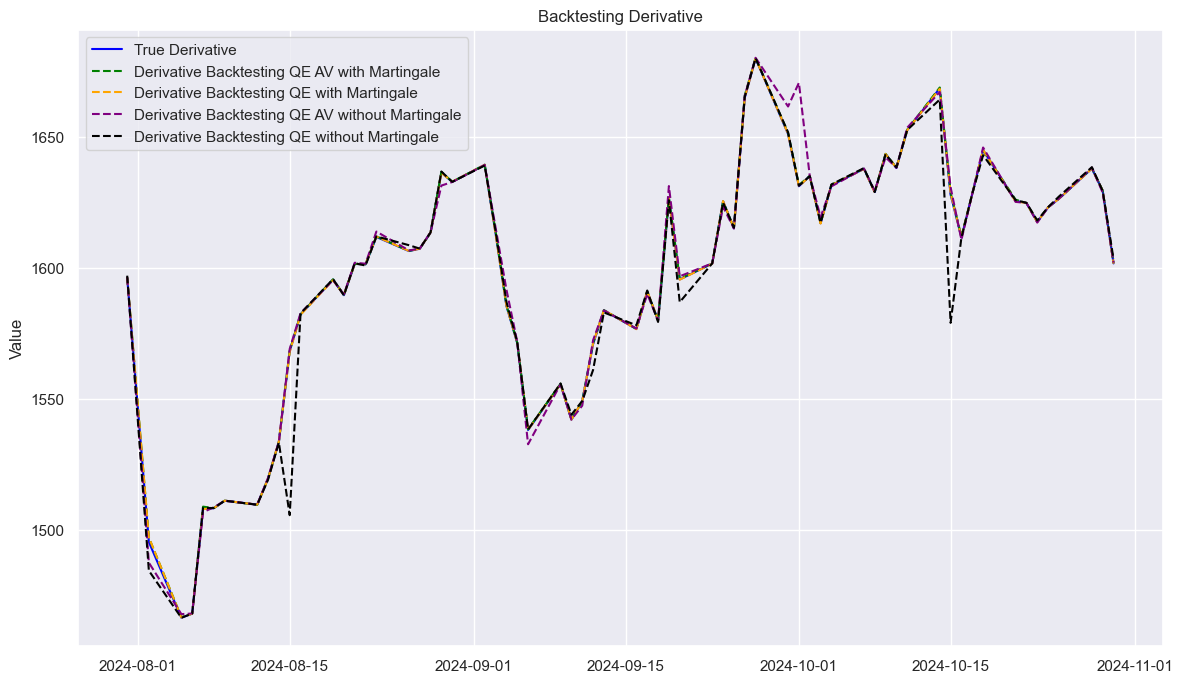

MSE for Derivative Backtesting QE AV with Martingale: 0.06491987892873452
MSE for Derivative Backtesting QE with Martingale: 0.11702119797053355
MSE for Derivative Backtesting QE AV CV with Martingale: 29.12140414787143
MSE for Derivative Backtesting QE CV with Martingale: 102.03101300304108


In [52]:
plt.figure(figsize=(14,8))
plt.plot(price_backtest_true.index[:-1], true_derivative, label="True Derivative", color="blue", linestyle="-")
plt.plot(price_backtest_true.index[:-1], derivative_backtest_heston_qe_with_martingale[1:], label="Derivative Backtesting QE AV with Martingale", color="green", linestyle="--")
plt.plot(price_backtest_true.index[:-1], derivative_backtest_heston_qe_av_with_martingale[1:], label="Derivative Backtesting QE with Martingale", color="orange", linestyle="--")
plt.plot(price_backtest_true.index[:-1], derivative_backtest_heston_qe_av_cv_with_martingale[1:], label="Derivative Backtesting QE AV without Martingale", color="purple", linestyle="--")
plt.plot(price_backtest_true.index[:-1], derivative_backtest_heston_qe_cv_with_martingale[1:], label="Derivative Backtesting QE without Martingale", color="black", linestyle="--")
# plt.plot(price_backtest_true.index[:-1], derivative_prices[1:], label="Derivative Backtesting QE without Martingale", color="black", linestyle="--")


plt.ylabel("Value")
plt.title("Backtesting Derivative")
plt.legend()

plt.show()


mse_derivative_backtest_heston_qe_with_martingale = mean_squared_error(true_derivative, derivative_backtest_heston_qe_with_martingale[1:])
mse_derivative_backtest_heston_qe_av_with_martingale = mean_squared_error(true_derivative, derivative_backtest_heston_qe_av_with_martingale[1:])
mse_derivative_backtest_heston_qe_av_cv_with_martingale = mean_squared_error(true_derivative, derivative_backtest_heston_qe_av_cv_with_martingale[1:])
mse_derivative_backtest_heston_qe_cv_with_martingale = mean_squared_error(true_derivative, derivative_backtest_heston_qe_cv_with_martingale[1:])

print(f"MSE for Derivative Backtesting QE AV with Martingale: {mse_derivative_backtest_heston_qe_av_with_martingale}")
print(f"MSE for Derivative Backtesting QE with Martingale: {mse_derivative_backtest_heston_qe_with_martingale}")
print(f"MSE for Derivative Backtesting QE AV CV with Martingale: {mse_derivative_backtest_heston_qe_av_cv_with_martingale}")
print(f"MSE for Derivative Backtesting QE CV with Martingale: {mse_derivative_backtest_heston_qe_cv_with_martingale}")


In [ ]:
def Pricer(price_matrix, price_history_matrix, S0 = 3487.05):
    # Assume buy 1 certificate
    n_trials = price_matrix.shape[0]
    barrier = S0/2
    redemptions = np.zeros(n_trials)
    barrier_hit = np.zeros(n_trials, dtype=bool)

    if np.any(price_history_matrix <= barrier):
        barrier_hit[:] = True
        print('Barrier Hit History')



    for i in range(n_trials):
        S_T = price_matrix[i, -1]
        barrier_hit[i] = np.any(price_matrix[i, :] <= barrier)
        if not barrier_hit[i]:
            redemptions[i] = max(1000, 1000 * (1 + 1.5 * (S_T - S0) / S0))
            print(redemptions[i])
        elif barrier_hit[i]:
            redemptions[i] = max(0, 1000 * (1 + (S_T - S0) / S0))



    avg_redemptions = np.mean(redemptions)
    
    redemptions_ROI = 1 + (avg_redemptions - 1000) / 1000
    return avg_redemptions, redemptions_ROI